In [1]:
# Basic imports
import matplotlib.pyplot as plt
import numpy as np
import math
# PyMC imports
import pymc as pm
import arviz as az
import seaborn as sb
# Scipy imports
from scipy.integrate import nquad
# other
#import harmonic as hm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# In the case that the covariance $\sigma$ is known, the Linear Regression model becomes a 1D case

Given a Bayesian Linear Regression model
$$
y_{i} = x_{i}\mathbf{\theta_{1}} + \epsilon
$$

Our parameter space is $\mathbf{\Theta} = \{\mathbf{\theta_{1}}, \log(\sigma^{2})\} \equiv \{\mathbf{\theta_{1}}, \theta_{2}\}$


**1. Likelihood Function**

You correctly wrote the likelihood function as:

$$
P(\mathbf{y}|\mathbf{\Theta}) = \frac{1}{(\sqrt{2\pi\sigma^{2}})^{N}} \exp\left( -\frac{(\mathbf{y} - \mathbf{X\theta_{1}})^{T}(\mathbf{y} - \mathbf{X\theta_{1}})}{2\sigma^{2}} \right)
$$

This is the standard form for the likelihood of a multivariate normal distribution with mean $\mathbf{X\theta_{1}}$ and covariance matrix $\sigma^{2} \mathbf{I}$.

**2. Prior Distribution**

Your prior for $\mathbf{\theta_{1}}$ is:

$$
P(\mathbf{\Theta}) = \frac{1}{(\sqrt{2\pi})^{p} \sqrt{|S_{1}|}} \exp\left( -\frac{\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}}{2S_{1}} \right)
$$

**3. Hamiltonian Derivation**

The Hamiltonian is given by:

$$
\begin{align*}
H(\mathbf{\Theta}) &= -\log\left( P(\mathbf{y}|\mathbf{\Theta}) P(\mathbf{\Theta}) \right) \\
&= -\log\left( \frac{1}{(2\pi\sigma^{2})^{N/2}} \frac{1}{(\sqrt{2\pi})^{p} \sqrt{|S_{1}|}} \exp\left( -\frac{(\mathbf{y} - \mathbf{X\theta_{1}})^{T}(\mathbf{y} - \mathbf{X\theta_{1}})}{2\sigma^{2}} - \frac{\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}}{2S_{1}} \right) \right) \\
&= \frac{N}{2}\log(2\pi\sigma^{2}) + \frac{p}{2}\log(2\pi S_{1}) + \frac{(\mathbf{y} - \mathbf{X\theta_{1}})^{T}(\mathbf{y} - \mathbf{X\theta_{1}})}{2\sigma^{2}} + \frac{\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}}{2S_{1}}
\end{align*}
$$


**Final Hamiltonian:**

$$
H(\mathbf{\Theta}) = \frac{N}{2}\log(2\pi\sigma^{2}) + \frac{p}{2}\log(2\pi S_{1}) + \frac{1}{2\sigma^{2}}(\mathbf{y} - \mathbf{X\theta_{1}})^{T}(\mathbf{y} - \mathbf{X\theta_{1}}) + \frac{1}{2S_{1}}\mathbf{\theta_{1}}^{T}\mathbf{\theta_{1}}
$$


In [2]:
def Hamiltonian(THETA: np.ndarray, MODEL: np.ndarray) -> float:
    x_mat = MODEL[0]
    y_vec = MODEL[1]
    sigma = MODEL[2]
    sigma_sq = sigma ** 2
    prior_cov = MODEL[3]
    N = len(y_vec)
    # P = len(THETA)

    y_hat = y_vec - (x_mat * THETA)

    #log_terms = (0.5 * N * np.log(2 * np.pi * sigma_sq * prior_cov))
    log_terms = 0.5*N*np.log(2*math.pi*sigma_sq) + 0.5*np.log(2*math.pi*prior_cov)
    prior_terms = 0.5 * (THETA**2) / prior_cov
    likelihood_terms = 0.5 * (y_hat.T @ y_hat) / sigma_sq

    return log_terms + prior_terms + likelihood_terms


In [3]:
def HamiltoninanPrime(THETA: float, MODEL: np.ndarray) -> np.ndarray:

    x_mat = MODEL[0]
    y_vec = MODEL[1]
    sigma = MODEL[2]
    sigma_sq = sigma**2
    prior_cov = MODEL[3]

    y_hat = y_vec - (THETA * x_mat)

    term1 = -x_mat.T @ y_hat
    term1 /= sigma_sq

    return term1 + (THETA / prior_cov)

def HamiltoninanDoublePrime(THETA: float, MODEL: np.ndarray) -> np.ndarray:
    x_mat = MODEL[0]
    sigma = MODEL[2]
    sigma_sq = sigma**2
    prior_cov = MODEL[3]

    return ((x_mat.T @ x_mat) / sigma_sq) + (1 / prior_cov)

In [4]:
def MAP_SOLUTIONS( MODEL: np.ndarray) -> np.ndarray:
    x_mat = MODEL[0]
    y_vec = MODEL[1]
    sigma = MODEL[2]
    sigma_sq = sigma**2
    prior_cov = MODEL[3]

    inv_term = ((x_mat.T @ x_mat) / sigma_sq) + (1/prior_cov)
    inv_term = 1/inv_term
    map_tht = np.dot(inv_term, (x_mat.T @ y_vec) / sigma_sq)

    return map_tht


In [37]:
np.random.seed(42)
N = 500
p = 1
X_vec = np.random.uniform(-10,10,N)
true_beta = 2
true_sigma = 5
epsilon = np.random.randn(N) * true_sigma
y_vec = (X_vec * true_beta) + epsilon
S_1 = 10
# sig2 = 10

MODEL = [X_vec, y_vec, true_sigma, S_1]

In [38]:
map_sol = MAP_SOLUTIONS(MODEL)
#map_sol = 0

print(f'Map solution: {map_sol}')

H0_map = Hamiltonian(map_sol, MODEL)
print(f'H0 at MAP: {H0_map}')

j = -HamiltoninanPrime(map_sol, MODEL)
print(f'j vector at MAP: {j}')

Dinv = HamiltoninanDoublePrime(map_sol, MODEL)
print(f'D at MAP: {Dinv}')

D = 1/Dinv
print(f'D inverse at MAP: {D}')

print(f'0.5 Dj_sq at MAP: {0.5*D*(j**2)}')

Map solution: 2.057180242637876
H0 at MAP: 1518.3447911492726
j vector at MAP: -6.420974862919593e-13
D at MAP: 712.4072356840727
D inverse at MAP: 0.0014036915262936275
0.5 Dj_sq at MAP: 2.893634155095025e-28


In [39]:
circ = 0.5*math.log(2 * np.pi * D)
print(f'0.5 * log(2pi|D|) at MAP: {circ}')

0.5 * log(2pi|D|) at MAP: -2.36538632086308


In [40]:
Log_Z_IFT = -H0_map + circ + 0.5*D*(j**2)
print(f'Log Z IFT: {Log_Z_IFT}')
Z_IFT = math.exp(Log_Z_IFT)
print(f'Z IFT: {Z_IFT}')

Log Z IFT: -1520.7101774701357
Z IFT: 0.0


In [41]:
def Q(THETA: float, MODEL: np.ndarray) -> np.ndarray:
    # theta = np.array([THETA])
    H = Hamiltonian(THETA, MODEL)
    return math.exp(-H)

In [42]:
N_Z, _ = nquad(Q, [[-np.inf, np.inf]], args=[MODEL], opts = {"epsabs" : 1e-16, "epsrel" : 1e-16})
print(f'Value of Z: {N_Z}')
print(f'Log Value of Z: {np.log(N_Z)}')

Value of Z: 0.0
Log Value of Z: -inf


/var/folders/xv/8r23mzm112ggs6n6_tvn5cn00000gn/T/ipykernel_56359/1913404364.py:3: RuntimeWarning: divide by zero encountered in log
  print(f'Log Value of Z: {np.log(N_Z)}')


In [43]:
abs(np.log(N_Z) - Log_Z_IFT)

/var/folders/xv/8r23mzm112ggs6n6_tvn5cn00000gn/T/ipykernel_56359/2347017130.py:1: RuntimeWarning: divide by zero encountered in log
  abs(np.log(N_Z) - Log_Z_IFT)


inf

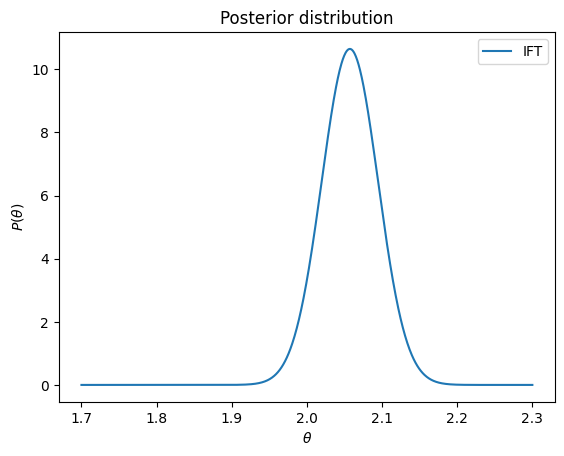

In [44]:
n_points = 1000
thetas = np.linspace(1.7, 2.3, n_points)

Q_vals = np.zeros(n_points)
Q_vals = np.array([math.exp(-Hamiltonian(theta, MODEL)) for theta in thetas])

posteriorIFT = np.exp([(-Hamiltonian(theta, MODEL)) for theta in thetas] - Log_Z_IFT)
#Q_vals_ift = Q_vals / Z_IFT
#Q_vals_ift = Q_vals_ift.reshape(-1)
#Q_vals_anl = Q_vals / N_Z
#Q_vals_anl = Q_vals_anl.reshape(-1)

# plt.plot(thetas, Q_vals, label='Likelihood')
plt.plot(thetas, posteriorIFT, label='IFT')
# plt.plot(thetas, Q_vals_anl, label='Analytical')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$P(\theta)$')
plt.title('Posterior distribution')
plt.legend()
plt.show()

In [45]:
with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=0, sigma=np.sqrt(S_1))
    #log_sigma2 = pm.Normal('log_sigma2', mu=0, sigma=np.sqrt(s2))
    #sigma2 = pm.Deterministic('sigma2', pm.math.exp(log_sigma2))
    #sigma = pm.Deterministic('sigma', pm.math.sqrt(sigma2))

    # Likelihood
    likelihood = pm.Normal('y', mu=X_vec * beta, sigma=true_sigma, observed=y_vec)

    # Sampling
    trace = pm.sample(1000, chains=4, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


array([[<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

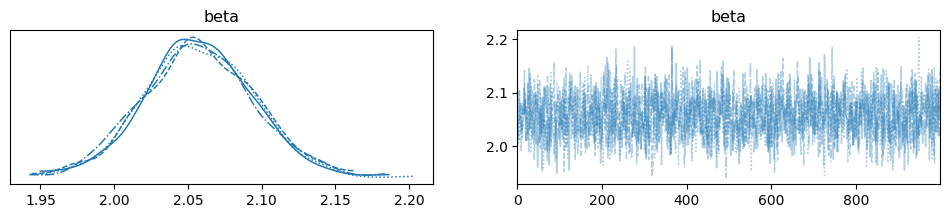

In [46]:
az.plot_trace(trace)

In [47]:

b_0_run = trace.posterior['beta'][0]
b_1_run = trace.posterior['beta'][1]
b_2_run = trace.posterior['beta'][2]
b_3_run = trace.posterior['beta'][3]

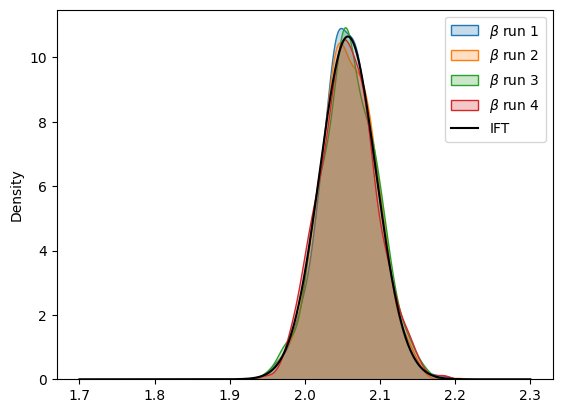

In [48]:
# For beta runs
sb.kdeplot(b_0_run, label=r"$\beta$ run 1", fill=True)
sb.kdeplot(b_1_run, label=r"$\beta$ run 2", fill=True)
sb.kdeplot(b_2_run, label=r"$\beta$ run 3", fill=True)
sb.kdeplot(b_3_run, label=r"$\beta$ run 4", fill=True)
plt.plot(thetas, posteriorIFT, label='IFT', color='black')
plt.legend()
plt.show()

In [49]:
# 